# Fluctuations of Hi-Hat Timing and Dynamics in a Virtuoso Drum Track of a Popular Music Recording

## [Paper](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0127902) by Esa Räsänen , Otto Pulkkinen, Tuomas Virtanen, Manfred Zollner, Holger Hennig

## Papers We Love presentation by Bryan Fink, January 21, 2016
Download images and data from the paper link above.

### Intro score
<img src="files/journal.pone.0127902.g007.PNG" />
"I Keep Forgettin'" as played by Jeff Porcaro

### Hit detection
<img src="files/journal.pone.0127902.g001.PNG" />
Images from the original paper

### Notebook setup

In [55]:
%matplotlib inline

import numpy as np               # useful general math functions
import pandas as pd              # useful timeseries functions
import matplotlib.pyplot as plt  # graphical plotting
import statsmodels.api as sm     # regression analysis
import scipy.optimize as spo     # more regression analysis

plt.style.use('ggplot')          # make our graphs look nicer

### Import data

In [56]:
drumdata = pd.read_csv('data/S1_Dataset.txt')
drumdata.head(5)

,onset,amplitude
0,0.109,0.310
1,0.440,0.402
2,0.574,0.038
3,0.742,0.063
4,0.895,0.044


In [57]:
# shift time such that the first hit is at time zero
drumdata.onset = drumdata.onset - drumdata.onset[0]
drumdata.head(5)

,onset,amplitude
0,0.000,0.310
1,0.331,0.402
2,0.465,0.038
3,0.633,0.063
4,0.786,0.044


### Calculating and scrubbing intervals

In [58]:
drumdata['interval'] = -1 * drumdata.onset.diff(-1)
drumdata.head(5)

,onset,amplitude,interval
0,0.000,0.310,0.331
1,0.331,0.402,0.134
2,0.465,0.038,0.168
3,0.633,0.063,0.153
4,0.786,0.044,0.163


In [59]:
bpm = 100.0
opb = 4.0
spm = 60.0
expected_interval = 1 / (opb * bpm / 60.0)
expected_interval

0.15

In [60]:
threshold = expected_interval * 1.5
under_threshold = drumdata.interval.where(drumdata.interval < threshold)
over_threshold = drumdata.interval.where(drumdata.interval > threshold)

(drumdata.interval.count(), threshold,
 under_threshold.count(), under_threshold.max(),
 over_threshold.count(), over_threshold.min())

(930, 0.22499999999999998, 708, 0.19400000000001683, 222, 0.26899999999997704)

In [61]:
under_threshold.mean()

0.1565607344632769

### Interval distribution

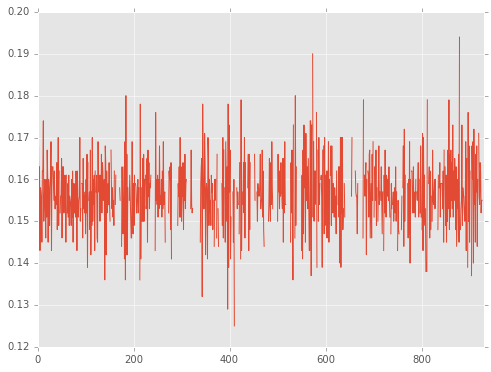

In [62]:
plt.figure(figsize=(8,6))
under_threshold.plot()

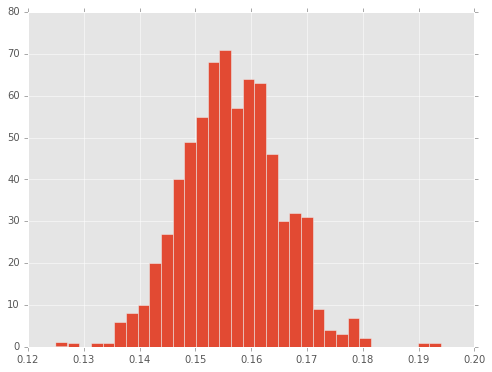

In [63]:
plt.figure(figsize=(8,6))
under_threshold.hist(bins=33)

### Drift

In [64]:
numclicks = drumdata.interval.div(under_threshold.mean()).round()
numclicks.head(5)

0    2
1    1
2    1
3    1
4    1
Name: interval, dtype: float64

In [65]:
drumdata['click_idx'] = numclicks.cumsum().shift()
drumdata['click_idx'][0] = 0
drumdata.head(5)

,onset,amplitude,interval,click_idx
0,0.000,0.310,0.331,0
1,0.331,0.402,0.134,2
2,0.465,0.038,0.168,3
3,0.633,0.063,0.153,4
4,0.786,0.044,0.163,5


In [66]:
mean_interval = drumdata.interval.sum()/numclicks.sum()
mean_interval

0.15749778106508874

In [67]:
drumdata['expected_onset'] = drumdata.click_idx * mean_interval
drumdata.head(5)

,onset,amplitude,interval,click_idx,expected_onset
0,0.000,0.310,0.331,0,0.000000
1,0.331,0.402,0.134,2,0.314996
2,0.465,0.038,0.168,3,0.472493
3,0.633,0.063,0.153,4,0.629991
4,0.786,0.044,0.163,5,0.787489


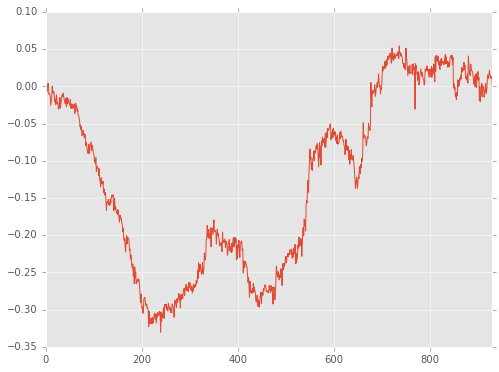

In [68]:
plt.figure(figsize=(8,6))
(drumdata.onset - drumdata.expected_onset).plot()

### Return time

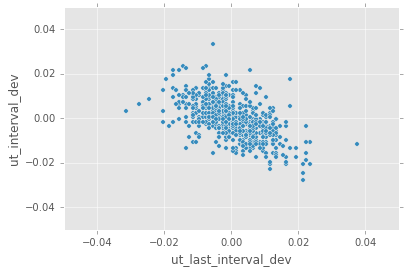

In [69]:
drumdata['ut_interval_dev'] = under_threshold - under_threshold.mean()
drumdata['ut_last_interval_dev'] = drumdata.ut_interval_dev.shift(-1)

plt.figure(figsize=(8,6))
drumdata.plot(kind='scatter', x='ut_last_interval_dev', y='ut_interval_dev')

In [70]:
drumdata.ut_interval_dev.autocorr(lag=1)

-0.56630170379958833

### Detrended Fluctuation Analysis

In [71]:
clickdata = drumdata[['onset', 'click_idx']].set_index('click_idx').reindex(range(0,int(drumdata.click_idx.max()))).interpolate()
clickdata.head(5)

,onset
click_idx,
0,0.0000
1,0.1655
2,0.3310
3,0.4650
4,0.6330


In [72]:
clickdata['interval'] = -1 * clickdata.onset.diff(-1)
clickdata['interval_dev'] = clickdata.interval - mean_interval
clickdata.head(5)

,onset,interval,interval_dev
click_idx,,,
0,0.0000,0.1655,0.008002
1,0.1655,0.1655,0.008002
2,0.3310,0.1340,-0.023498
3,0.4650,0.1680,0.010502
4,0.6330,0.1530,-0.004498


In [73]:
# y(i) from the paper
clickdata['interval_dev_int'] = clickdata['interval_dev'].cumsum()
clickdata.head(5)

,onset,interval,interval_dev,interval_dev_int
click_idx,,,,
0,0.0000,0.1655,0.008002,0.008002
1,0.1655,0.1655,0.008002,0.016004
2,0.3310,0.1340,-0.023498,-0.007493
3,0.4650,0.1680,0.010502,0.003009
4,0.6330,0.1530,-0.004498,-0.001489


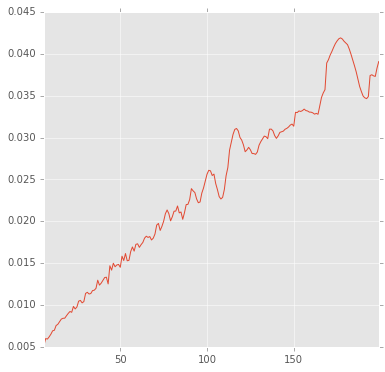

In [74]:
# y_s(i) from the paper
def segment_regression(range):
    return pd.Series(sm.OLS(clickdata.interval_dev_int[range], range).fit().predict(range), range)

# F_k(s) from the paper
def segment_fluctuation(k, s):
    x = range(k*s, k*s+s)
    return np.sqrt(((clickdata.interval_dev_int[x] - segment_regression(x))**2).sum() / s)

# F(s)
def fluctuation(s):
    return pd.Series(range(0, clickdata.interval_dev_int.count()/s)).map(lambda k: segment_fluctuation(k, s)).mean()

segment_sizes = range(6, 200)
flucdata = pd.Series(segment_sizes, segment_sizes).map(fluctuation)

plt.figure(figsize=(6,6))
flucdata.plot()

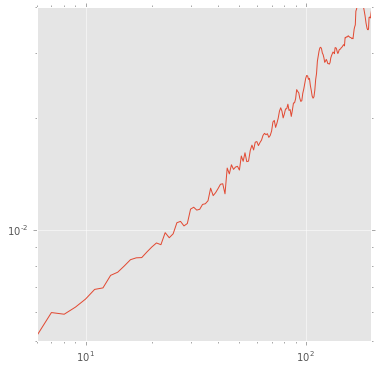

In [75]:
plt.figure(figsize=(6,6))
plt.ylim(0.005, 0.040)
flucdata.plot(logx=True, logy=True)

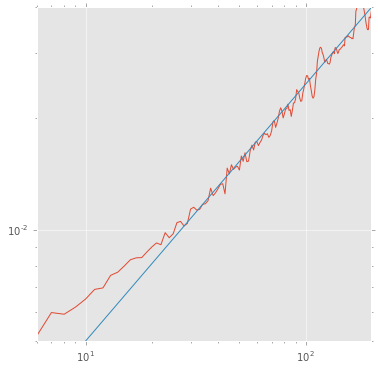

In [76]:
# the s**alpha function we're trying to fit to this data
def noise_fit(x, a, b):
    return np.power(x, a)/b

wfopt, wfconv = spo.curve_fit(noise_fit, segment_sizes, flucdata.tolist())
plt.figure(figsize=(6,6))
plt.ylim(0.005, 0.040)
flucdata.plot(logx=True, logy=True)
pd.Series(noise_fit(segment_sizes, *wfopt), segment_sizes).plot(logx=True, logy=True)

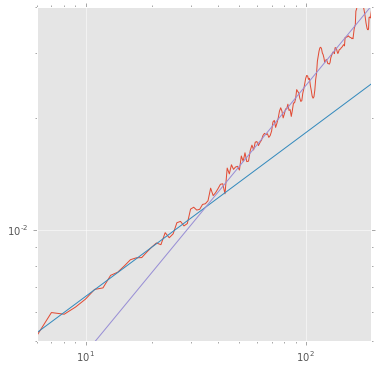

In [77]:
smrange = range(flucdata.index.min(),30)
smopt, smconv = spo.curve_fit(noise_fit, smrange, flucdata[smrange].tolist())
lgrange = range(50,flucdata.index.max())
lgopt, lgconv = spo.curve_fit(noise_fit, lgrange, flucdata[lgrange].tolist())

plt.figure(figsize=(6,6))
plt.ylim(0.005, 0.040)
flucdata.plot(logx=True, logy=True)
pd.Series(noise_fit(segment_sizes, *smopt), segment_sizes).plot(logx=True, logy=True)
pd.Series(noise_fit(segment_sizes, *lgopt), segment_sizes).plot(logx=True, logy=True)

In [78]:
smopt[0] # the alpha value that fit

0.44169680907188169

In [79]:
lgopt[0]

0.72118923722852535